In [20]:
pip install -r requirements.txt


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip uninstall notebook traitlets jupyter

In [ ]:
!pip install --upgrade notebook==6.4.12 traitlets==5.9.0 jupyter jupyter_contrib_nbextensions


In [ ]:
!pip install --upgrade notebook==6.4.12 traitlets==5.9.0 jupyter jupyter_contrib_nbextensions nglview mdtraj


In [2]:
!jupyter contrib nbextension install --user

[I 13:17:45 InstallContribNbextensionsApp] jupyter contrib nbextension install --user
[I 13:17:45 InstallContribNbextensionsApp] Installing jupyter_contrib_nbextensions nbextension files to jupyter data directory
[I 13:17:45 InstallContribNbextensionsApp] Installing /usr/local/python/3.10.13/lib/python3.10/site-packages/jupyter_contrib_nbextensions/nbextensions/contrib_nbextensions_help_item -> contrib_nbextensions_help_item
[I 13:17:45 InstallContribNbextensionsApp] Making directory: /home/codespace/.local/share/jupyter/nbextensions/contrib_nbextensions_help_item/
[I 13:17:45 InstallContribNbextensionsApp] Copying: /usr/local/python/3.10.13/lib/python3.10/site-packages/jupyter_contrib_nbextensions/nbextensions/contrib_nbextensions_help_item/contrib_nbextensions_help_item.yaml -> /home/codespace/.local/share/jupyter/nbextensions/contrib_nbextensions_help_item/contrib_nbextensions_help_item.yaml
[I 13:17:45 InstallContribNbextensionsApp] Copying: /usr/local/python/3.10.13/lib/python3.10

In [4]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: problems found:
        - require?  X jupyter-js-widgets/extension


## Demo Project Analytic here

In [ ]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def vectorize_log_file(file_path, vectorizer=None, fit=True):
    all_sentence = []
    with open(file_path, 'r') as file:
        log_content = file.read().strip().split('\n')
        all_sentence.append(extract_all_word_from_log(log_content))
    if not log_content:
        raise ValueError(f"The log file {file_path} is empty or contains only whitespace.")
    if fit:
        log_vector = vectorizer.fit_transform(all_sentence)
    else:
        log_vector = vectorizer.transform(all_sentence)
    return log_vector.toarray()[0]

def extract_all_word_from_log(log_context):
    words = ""
    for line in log_context:
        words += line.split('|')[-1].strip()
    return words

def parse_execution_trace(file_path):
    return pd.read_csv(file_path)

def get_total_line_of_code(file_path):
    data = None
    with open(file_path, 'r') as input_file:
        data = json.load(input_file)
    return data

def vectorize_execution_trace(trace_df, unique_methods, total_lines_of_code):
    execution_vectors = {}
    for method in unique_methods:
        coverage = {path: [0] * lines for path, lines in total_lines_of_code.items()}
        method_trace = trace_df[trace_df['signature'] == method]
        method = method.replace('src/test/java/functions/CalculatorTest.java;CalculatorTest.', '')
        method = method.replace('#', '')
        for _, row in trace_df.iterrows():
            if str(row['line_no']) in map(str, method_trace['line_no'].values):
                coverage[row['path'].split(';')[0]][row['line_no'] - 1] = 1
        execution_vectors[method] = [x for y in coverage.values() for x in y]
    return execution_vectors

def extract_result(coverage_vector_result, total_lines_of_code):
    result = {}
    for path, lines in total_lines_of_code.items():
        result[path] = extract_line_from_result(coverage_vector_result[:lines])
        coverage_vector_result = coverage_vector_result[lines:]
    return result

def extract_line_from_result(result):
    lines = []
    for index, value in enumerate(result):
        if value == 1:
            lines.append(index)
    return lines

def align_lists(a, b):
    i, j = 0, 0
    new_a, new_b = [], []
    while i < len(a) and j < len(b):
        if a[i] == b[j]:
            new_a.append(a[i])
            new_b.append(b[j])
            i += 1
            j += 1
        elif a[i] < b[j]:
            new_a.append(a[i])
            new_b.append(0)
            i += 1
        else:
            new_a.append(0)
            new_b.append(b[j])
            j += 1
    while i < len(a):
        new_a.append(a[i])
        new_b.append(0)
        i += 1
    while j < len(b):
        new_a.append(0)
        new_b.append(b[j])
        j += 1
    return new_a, new_b

def evaluate_predictions(method_test, y_test, y_pred, total_lines_of_code):
    prediction_percentage = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    for i in range(len(y_test)):
        actual_coverage = extract_result(y_test[i], total_lines_of_code)
        predicted_coverage = extract_result(y_pred[i], total_lines_of_code)
        for path in total_lines_of_code.keys():
            actual = actual_coverage[path]
            predicted = predicted_coverage[path]
            actual, predicted = align_lists(actual, predicted)
        acc = accuracy_score(*align_lists(extract_line_from_result(y_test[i]), extract_line_from_result(y_pred[i])))
        prec = precision_score(y_test[i], y_pred[i])
        recall = recall_score(y_test[i], y_pred[i])
        f1 = f1_score(y_test[i], y_pred[i])
        prediction_percentage.append(acc)
        precision_scores.append(prec)
        recall_scores.append(recall)
        f1_scores.append(f1)
    return prediction_percentage, precision_scores, recall_scores, f1_scores

# Directory structure
base_directory = 'data/TestEffortEstimationtutorial/percentage_of_removed_log'
total_lines_of_code = get_total_line_of_code('data/TestEffortEstimationtutorial/line_of_code-demo.json')
# Lists to store results
overall_accuracies = []
overall_precisions = []
overall_recalls = []
overall_f1s = []
percentages = []


# Iterate through each dataset directory
for folder in sorted(os.listdir(base_directory)):
    folder_path = os.path.join(base_directory, folder)
    if not os.path.isdir(folder_path):
        continue

    percentage = int(folder)
    percentages.append(percentage)

    acc_list = []
    prec_list = []
    recall_list = []
    f1_list = []

    for attempt in sorted(os.listdir(folder_path)):
        attempt_path = os.path.join(folder_path, attempt)
        if not os.path.isdir(attempt_path):
            continue

        log_directory = os.path.join(attempt_path, 'logs')
        trace_file = os.path.join(attempt_path, 'trace_data.csv')

        trace_df = parse_execution_trace(trace_file)
        trace_df = trace_df[~trace_df['path'].str.contains(r'\btest\b|\bTest\b', regex=True)]
        trace_df['line_no'] = trace_df['path'].apply(lambda x: int(x.split('@')[1]))
        unique_methods = trace_df['signature'].unique()

        execution_vectors = vectorize_execution_trace(trace_df, unique_methods, total_lines_of_code)

        log_vectors = []
        execution_vectors_for_model = []
        method_names = []

        vectorizer = CountVectorizer()

        for method in unique_methods:
            method = method.replace('src/test/java/functions/CalculatorTest.java;CalculatorTest.', '')
            method = method.replace('#', '')
            log_file_path = os.path.join(log_directory, f"log_{method}.log")
            log_file_path = log_file_path.replace('"', '')

            if os.path.exists(log_file_path):
                try:
                    log_vector = vectorize_log_file(log_file_path, vectorizer, fit=True)
                    log_vectors.append(log_vector)
                    execution_vectors_for_model.append(execution_vectors[method])
                    method_names.append(method)
                except ValueError as e:
                    print(e)
            else:
                print(f"Log file for method {method} not found.")

        if len(log_vectors) < 2 or len(execution_vectors_for_model) < 2:
            print(f"Insufficient data for percentage {percentage}, attempt {attempt}. Skipping...")
            continue

        max_log_length = max(len(v) for v in log_vectors)
        max_exec_length = max(len(v) for v in execution_vectors_for_model)

        padded_log_vectors = np.array([np.pad(v, (0, max_log_length - len(v)), 'constant') for v in log_vectors])
        padded_execution_vectors = np.array([np.pad(v, (0, max_exec_length - len(v)), 'constant') for v in execution_vectors_for_model])

        X = np.array(padded_log_vectors)
        y = np.array(padded_execution_vectors)

        y = y.astype(int)

        if len(X) < 2 or len(y) < 2:
            print(f"Not enough data to split for percentage {percentage}, attempt {attempt}. Skipping...")
            continue

        X_train, X_test, y_train, y_test, method_train, method_test = train_test_split(X, y, method_names, test_size=0.3, random_state=42)

        if len(X_train) == 0 or len(y_train) == 0 or len(X_test) == 0 or len(y_test) == 0:
            print(f"Train or test split is empty for percentage {percentage}, attempt {attempt}. Skipping...")
            continue

        model = RandomForestClassifier()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        acc, prec, recall, f1 = evaluate_predictions(method_test, y_test, y_pred, total_lines_of_code)

        acc_list.append(np.mean(acc))
        prec_list.append(np.mean(prec))
        recall_list.append(np.mean(recall))
        f1_list.append(np.mean(f1))

    if not acc_list or not prec_list or not recall_list or not f1_list:
        print(f"No valid data for percentage {percentage}. Skipping...")
        continue

    overall_accuracies.append(np.mean(acc_list))
    overall_precisions.append(np.mean(prec_list))
    overall_recalls.append(np.mean(recall_list))
    overall_f1s.append(np.mean(f1_list))

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(percentages, overall_accuracies, label='Accuracy')
plt.plot(percentages, overall_precisions, label='Precision')
plt.plot(percentages, overall_recalls, label='Recall')
plt.plot(percentages, overall_f1s, label='F1 Score')
plt.xlabel('Percentage of Removed Log')
plt.ylabel('Score')
plt.title('Evaluation Metrics for Coverage Across Different Log Removal Percentages')
plt.xticks(percentages, [f'{p}%' for p in percentages])
plt.legend()
plt.show()


: 

## Real Project but Testing dataset

In [ ]:
import os
import pandas as pd
import json
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def get_total_line_of_code(file_path):
    data = None
    with open(file_path, 'r') as input_file:
        data = json.load(input_file)
    return data

total_lines_of_code = get_total_line_of_code('data/rxjava-jdbc/line_of_code.json')


# Function to parse execution trace
def parse_execution_trace(file_path):
    return pd.read_csv(file_path)

def vectorize_execution_trace(trace_df, unique_methods):
    execution_vectors = {}

    for method in unique_methods:
        coverage = {path: [0] * lines for path, lines in total_lines_of_code.items()}
        method_trace = trace_df[trace_df['method'] == method]

        for _, row in trace_df.iterrows():
            if str(row['line_no']) in map(str, method_trace['line_no'].values):
                coverage[row['path'].split(';')[0]][row['line_no']-1] = 1
        execution_vectors[method] = [x for y in coverage.values() for x in y]
    return execution_vectors

def extract_all_word_from_log(log_context):
    words = ""
    for line in log_context:
        words += line.split('|')[-1].strip()

    return words

def vectorize_log_file(file_path, vectorizer=None, fit=True):
    all_sentence = []
    with open(file_path, 'r') as file:
        log_content = file.read().strip().split('\n')
        all_sentence.append(extract_all_word_from_log(log_content))
    if not log_content:
        raise ValueError(f"The log file {file_path} is empty or contains only whitespace.")
    if fit:
        log_vector = vectorizer.fit_transform(all_sentence)
        
    else:
        log_vector = vectorizer.transform(all_sentence)
    return log_vector.toarray()[0]

trace_file = 'data/trial/trace_data.csv'
log_directory = 'data/trial/logs'

trace_df = parse_execution_trace(trace_file)

trace_df = trace_df[~trace_df['path'].str.contains(r'\btest\b|\bTest\b', regex=True)]
trace_df['line_no'] = trace_df['path'].apply(lambda x: int(x.split('@')[1]))
trace_df['method'] = trace_df['signature'].str.replace(r'.*?\.java;.*?\.', '', regex=True).str.replace('#', '', regex=True)
unique_methods = trace_df['method'].unique()

execution_vectors =  vectorize_execution_trace(trace_df, unique_methods)

log_vectors = []
execution_vectors_for_model = []
method_names = [] 

vectorizer = CountVectorizer()

for method in unique_methods:

    log_file_path = os.path.join(log_directory, f"log_{method}.log")
    log_file_path = log_file_path.replace('"', '')
    
    if os.path.exists(log_file_path):
        try:
            log_vector = vectorize_log_file(log_file_path, vectorizer, fit=True)
            log_vectors.append(log_vector)
            execution_vectors_for_model.append(execution_vectors[method])
            method_names.append(method)
        except ValueError as e:
            print(e)
    else:
        print(f"Log file for method {method} not found.")

if not log_vectors or not execution_vectors_for_model:
    raise ValueError("Log vectors or execution vectors for model are empty. Check your data.")

max_log_length = max(len(v) for v in log_vectors)
max_exec_length = max(len(v) for v in execution_vectors_for_model)

padded_log_vectors = np.array([np.pad(v, (0, max_log_length - len(v)), 'constant') for v in log_vectors])
padded_execution_vectors = np.array([np.pad(v, (0, max_exec_length - len(v)), 'constant') for v in execution_vectors_for_model])

X = np.array(padded_log_vectors)
y = np.array(padded_execution_vectors)

y = y.astype(int)

X_train, X_test, y_train, y_test, method_train, method_test = train_test_split(X, y, method_names, test_size=0.3, random_state=42)

# Print shapes for debugging
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Train the Random Forest model
model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

def extract_result(coverage_vector_result):
    result = {}
    for path, lines in total_lines_of_code.items():
        result[path] = coverage_vector_result[:lines]
        coverage_vector_result = coverage_vector_result[lines:]
    return result

def extract_line_from_result(result):
    lines = []
    for index, value in enumerate(result):
        if value == 1:
            lines.append(index)
    return lines


def align_lists(a, b):
    # Initialize indexes
    i, j = 0, 0

    # New lists with inserted 0s
    new_a, new_b = [], []

    while i < len(a) and j < len(b):
        if a[i] == b[j]:
            new_a.append(a[i])
            new_b.append(b[j])
            i += 1
            j += 1
        elif a[i] < b[j]:
            new_a.append(a[i])
            new_b.append(0)
            i += 1
        else:
            new_a.append(0)
            new_b.append(b[j])
            j += 1

    # Append remaining elements
    while i < len(a):
        new_a.append(a[i])
        new_b.append(0)
        i += 1

    while j < len(b):
        new_a.append(0)
        new_b.append(b[j])
        j += 1

    return new_a, new_b

def evaluate_predictions(method_test, y_test, y_pred):
    prediction_percentage = []
    preision_scores = []
    recall_scores = []
    f1_scores = []

    for i in range(len(y_test)):
        actual_coverage = extract_result(y_test[i])
        predicted_coverage = extract_result(y_pred[i])
        print(f"Method: {method_test[i]}")
        # for path in total_lines_of_code.keys():
            # actual = actual_coverage[path]
            # predicted = predicted_coverage[path]
            # # actual, predicted = align_lists(actual, predicted)
            # print(f"  {path}")
            # print(f"    Actual: {actual}")
            # print(f"    Predicted: {predicted}")
            # print(f'    Accuracy: {accuracy_score(actual, predicted):.2%}')
            
        # print(f"   Actual   : {y_test[i]}")
        print(f"      number of 0: {len(y_test[i]) - np.count_nonzero(y_test[i])}")
        # print(f"   Predicted: {y_pred[i]}")
        print(f"      number of 0: {len(y_pred[i]) - np.count_nonzero(y_pred[i])}")


        # print(f'  Accuracy: {correct/len(y_test[i]):.2%}')
        conf_matrix = confusion_matrix(y_test[i], y_pred[i])
        print("Confusion Metric:")
        print(conf_matrix)
        acc = accuracy_score(*align_lists(extract_line_from_result(y_test[i]), extract_line_from_result(y_pred[i])))
        prec = precision_score(y_test[i], y_pred[i])
        recall = recall_score(y_test[i], y_pred[i])
        f1 = f1_score(y_test[i], y_pred[i])
        print(f'  Accuracy: {acc:.2%}')
        print(f'  Precision: {prec:.2%}')
        print(f'  Recall: {recall:.2%}')
        print(f'  F1 Score: {f1:.2%}')
        print()

        prediction_percentage.append(acc)
        preision_scores.append(prec)
        recall_scores.append(recall)
        f1_scores.append(f1)
        
    print("Overall Accuracy: ", sum(prediction_percentage)/len(prediction_percentage))
    print("Overall Precision: ", sum(preision_scores)/len(preision_scores))
    print("Overall Recall: ", sum(recall_scores)/len(recall_scores))
    print("Overall F1 Score: ", sum(f1_scores)/len(f1_scores))


# Evaluate the predictions
evaluate_predictions(method_test, y_test, y_pred)


In [ ]:
import os
import pandas as pd
import json
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def get_total_line_of_code(file_path):
    data = None
    with open(file_path, 'r') as input_file:
        data = json.load(input_file)
    return data

total_lines_of_code = get_total_line_of_code('data/TestEffortEstimationtutorial/line_of_code-demo.json')


# Function to parse execution trace
def parse_execution_trace(file_path):
    return pd.read_csv(file_path)

def vectorize_execution_trace(trace_df, unique_methods):
    execution_vectors = {}

    for method in unique_methods:
        coverage = {path: [0] * lines for path, lines in total_lines_of_code.items()}
        method_trace = trace_df[trace_df['method'] == method]

        for _, row in trace_df.iterrows():
            if str(row['line_no']) in map(str, method_trace['line_no'].values):
                coverage[row['path'].split(';')[0]][row['line_no']-1] = 1
        execution_vectors[method] = [x for y in coverage.values() for x in y]
    return execution_vectors

def extract_all_word_from_log(log_context):
    words = ""
    for line in log_context:
        words += line.split('|')[-1].strip()

    return words

def vectorize_log_file(file_path, vectorizer=None, fit=True):
    all_sentence = []
    with open(file_path, 'r') as file:
        log_content = file.read().strip().split('\n')
        all_sentence.append(extract_all_word_from_log(log_content))
    if not log_content:
        raise ValueError(f"The log file {file_path} is empty or contains only whitespace.")
    if fit:
        log_vector = vectorizer.fit_transform(all_sentence)
        
    else:
        log_vector = vectorizer.transform(all_sentence)
    return log_vector.toarray()[0]

trace_file = 'data/TestEffortEstimationtutorial/percentage_of_removed_log/0/1/trace_data.csv'
log_directory = 'data/TestEffortEstimationtutorial/percentage_of_removed_log/0/1/logs'

trace_df = parse_execution_trace(trace_file)

trace_df = trace_df[~trace_df['path'].str.contains(r'\btest\b|\bTest\b', regex=True)]
trace_df['line_no'] = trace_df['path'].apply(lambda x: int(x.split('@')[1]))
trace_df['method'] = trace_df['signature'].str.replace(r'.*?\.java;.*?\.', '', regex=True).str.replace('#', '', regex=True)
unique_methods = trace_df['method'].unique()

execution_vectors =  vectorize_execution_trace(trace_df, unique_methods)

log_vectors = []
execution_vectors_for_model = []
method_names = [] 

vectorizer = CountVectorizer()

for method in unique_methods:

    log_file_path = os.path.join(log_directory, f"log_{method}.log")
    log_file_path = log_file_path.replace('"', '')
    
    if os.path.exists(log_file_path):
        try:
            log_vector = vectorize_log_file(log_file_path, vectorizer, fit=True)
            log_vectors.append(log_vector)
            execution_vectors_for_model.append(execution_vectors[method])
            method_names.append(method)
        except ValueError as e:
            print(e)
    else:
        print(f"Log file for method {method} not found.")

if not log_vectors or not execution_vectors_for_model:
    raise ValueError("Log vectors or execution vectors for model are empty. Check your data.")

max_log_length = max(len(v) for v in log_vectors)
max_exec_length = max(len(v) for v in execution_vectors_for_model)

padded_log_vectors = np.array([np.pad(v, (0, max_log_length - len(v)), 'constant') for v in log_vectors])
padded_execution_vectors = np.array([np.pad(v, (0, max_exec_length - len(v)), 'constant') for v in execution_vectors_for_model])

X = np.array(padded_log_vectors)
y = np.array(padded_execution_vectors)

y = y.astype(int)

X_train, X_test, y_train, y_test, method_train, method_test = train_test_split(X, y, method_names, test_size=0.3, random_state=42)

# Print shapes for debugging
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Train the Random Forest model
model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


import numpy as np


def extract_result(coverage_vector_result, total_lines_of_code):
    result = {}
    for path, lines in total_lines_of_code.items():
        result[path] = extract_line_from_result(coverage_vector_result[:lines])
        coverage_vector_result = coverage_vector_result[lines:]
    return result


def extract_line_from_result(result):
    lines = []
    for index, value in enumerate(result):
        if value == 1:
            lines.append(index)
    return lines


def align_lists(a, b):
    # Initialize indexes
    i, j = 0, 0

    # New lists with inserted 0s
    new_a, new_b = [], []

    while i < len(a) and j < len(b):
        if a[i] == b[j]:
            new_a.append(a[i])
            new_b.append(b[j])
            i += 1
            j += 1
        elif a[i] < b[j]:
            new_a.append(a[i])
            new_b.append(0)
            i += 1
        else:
            new_a.append(0)
            new_b.append(b[j])
            j += 1

    # Append remaining elements
    while i < len(a):
        new_a.append(a[i])
        new_b.append(0)
        i += 1

    while j < len(b):
        new_a.append(0)
        new_b.append(b[j])
        j += 1

    return new_a, new_b

def calculate_accuracy(y_test, y_pred):
    correct = sum(1 for a, p in zip(y_test, y_pred) if a == p)
    return correct / len(y_test)

def calculate_precision_recall_f1(y_test, y_pred):
    TP = sum(1 for a, p in zip(y_test, y_pred) if a == p and a != 0)
    FP = sum(1 for a, p in zip(y_test, y_pred) if a == 0 and p != 0)
    FN = sum(1 for a, p in zip(y_test, y_pred) if a != 0 and p == 0)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

def evaluate_predictions(method_test, y_test, y_pred, total_lines_of_code):
    prediction_percentage = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    for i in range(len(y_test)):
        actual_coverage = extract_result(y_test[i], total_lines_of_code)
        predicted_coverage = extract_result(y_pred[i], total_lines_of_code)
        
        total_acc = []
        total_prec = []
        total_recall = []
        total_f1 = []
        for path in total_lines_of_code.keys():
            actual = actual_coverage[path]
            predicted = predicted_coverage[path]
            actual, predicted = align_lists(actual, predicted)
            
            if len(actual) == 0:
                continue
            
            acc = calculate_accuracy(actual, predicted)
            prec, recall, f1 = calculate_precision_recall_f1(actual, predicted)
            
            total_acc.append(acc)
            total_prec.append(prec)
            total_recall.append(recall)
            total_f1.append(f1)

        acc = np.mean(total_acc)
        prec = np.mean(total_prec)
        recall = np.mean(total_recall)
        f1 = np.mean(total_f1)  

        prediction_percentage.append(acc)
        precision_scores.append(prec)
        recall_scores.append(recall)
        f1_scores.append(f1)
    
    print(f"Accuracy: {sum(prediction_percentage)/len(prediction_percentage)}")
    print(f"Precision: {sum(precision_scores)/len(precision_scores)}")
    print(f"Recall: {sum(recall_scores)/len(recall_scores)}")
    print(f"F1 Score: {sum(f1_scores)/len(f1_scores)}")

    return prediction_percentage, precision_scores, recall_scores, f1_scores

def only_0_model(y_test):
    return np.zeros_like(y_test)

def only_1_model(y_test):
    return np.ones_like(y_test)

def random_model(y_test):
    return np.random.randint(0, 2, size=y_test.shape)

def evaluate_comparison_models(method_test, y_test, total_lines_of_code):
    y_pred_only_0 = only_0_model(y_test)
    y_pred_only_1 = only_1_model(y_test)
    
    y_pred_random = random_model(y_test)

    acc_only_0, prec_only_0, recall_only_0, f1_only_0 = evaluate_predictions(method_test, y_test, y_pred_only_0, total_lines_of_code)
    acc_only_1, prec_only_1, recall_only_1, f1_only_1 = evaluate_predictions(method_test, y_test, y_pred_only_1, total_lines_of_code)
    acc_random, prec_random, recall_random, f1_random = evaluate_predictions(method_test, y_test, y_pred_random, total_lines_of_code)
    
    return {
        "only_0": (acc_only_0, prec_only_0, recall_only_0, f1_only_0),
        "only_1": (acc_only_1, prec_only_1, recall_only_1, f1_only_1),
        "random": (acc_random, prec_random, recall_random, f1_random)
    }
           


# Evaluate the predictions
evaluate_predictions(method_test, y_test, y_pred, total_lines_of_code)


## Real World Project Analytic here

In [1]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm.notebook import tqdm 

def vectorize_log_file(file_path, vectorizer=None, fit=True):
    all_sentence = []
    with open(file_path, 'r') as file:
        log_content = file.read().strip().split('\n')
        all_sentence.append(extract_all_word_from_log(log_content))
    if not log_content:
        raise ValueError(f"The log file {file_path} is empty or contains only whitespace.")
    if fit:
        log_vector = vectorizer.fit_transform(all_sentence)
    else:
        log_vector = vectorizer.transform(all_sentence)
    return log_vector.toarray()[0]

def extract_all_word_from_log(log_context):
    words = ""
    for line in log_context:
        words += line.split('|')[-1].strip()
    return words

def parse_execution_trace(file_path):
    return pd.read_csv(file_path)

def get_total_line_of_code(file_path):
    data = None
    with open(file_path, 'r') as input_file:
        data = json.load(input_file)
    return data

def vectorize_execution_trace(trace_df, unique_methods, total_lines_of_code):
    execution_vectors = {}

    for method in unique_methods:
        coverage = {path: [0] * lines for path, lines in total_lines_of_code.items()}
        method_trace = trace_df[trace_df['method'] == method]

        for _, row in trace_df.iterrows():
            if str(row['line_no']) in map(str, method_trace['line_no'].values):
                coverage[row['path'].split(';')[0]][row['line_no']-1] = 1
        execution_vectors[method] = [x for y in coverage.values() for x in y]
    return execution_vectors

def extract_result(coverage_vector_result, total_lines_of_code):
    result = {}
    for path, lines in total_lines_of_code.items():
        result[path] = extract_line_from_result(coverage_vector_result[:lines])
        coverage_vector_result = coverage_vector_result[lines:]
    return result

def extract_line_from_result(result):
    lines = []
    for index, value in enumerate(result):
        if value == 1:
            lines.append(index)
    return lines

def align_lists(a, b):
    i, j = 0, 0
    new_a, new_b = [], []
    while i < len(a) and j < len(b):
        if a[i] == b[j]:
            new_a.append(a[i])
            new_b.append(b[j])
            i += 1
            j += 1
        elif a[i] < b[j]:
            new_a.append(a[i])
            new_b.append(0)
            i += 1
        else:
            new_a.append(0)
            new_b.append(b[j])
            j += 1
    while i < len(a):
        new_a.append(a[i])
        new_b.append(0)
        i += 1
    while j < len(b):
        new_a.append(0)
        new_b.append(b[j])
        j += 1
    return new_a, new_b


def calculate_accuracy(y_test, y_pred):
    correct = sum(1 for a, p in zip(y_test, y_pred) if a == p)
    return correct / len(y_test)

def calculate_precision_recall_f1(y_test, y_pred):
    TP = sum(1 for a, p in zip(y_test, y_pred) if a == p and a != 0)
    FP = sum(1 for a, p in zip(y_test, y_pred) if a == 0 and p != 0)
    FN = sum(1 for a, p in zip(y_test, y_pred) if a != 0 and p == 0)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1
def evaluate_predictions(method_test, y_test, y_pred, total_lines_of_code):
    prediction_percentage = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    for i in range(len(y_test)):
        actual_coverage = extract_result(y_test[i], total_lines_of_code)
        predicted_coverage = extract_result(y_pred[i], total_lines_of_code)
        
        total_acc = []
        total_prec = []
        total_recall = []
        total_f1 = []
        for path in total_lines_of_code.keys():
            actual = actual_coverage[path]
            predicted = predicted_coverage[path]
            actual, predicted = align_lists(actual, predicted)
            
            if len(actual) == 0:
                continue
            
            acc = calculate_accuracy(actual, predicted)
            prec, recall, f1 = calculate_precision_recall_f1(actual, predicted)
            
            total_acc.append(acc)
            total_prec.append(prec)
            total_recall.append(recall)
            total_f1.append(f1)

        acc = np.mean(total_acc)
        prec = np.mean(total_prec)
        recall = np.mean(total_recall)
        f1 = np.mean(total_f1)  

        prediction_percentage.append(acc)
        precision_scores.append(prec)
        recall_scores.append(recall)
        f1_scores.append(f1)

    return prediction_percentage, precision_scores, recall_scores, f1_scores

def only_0_model(y_test):
    return np.zeros_like(y_test)

def only_1_model(y_test):
    return np.ones_like(y_test)

def random_model(y_test):
    return np.random.randint(0, 2, size=y_test.shape)

def evaluate_comparison_models(method_test, y_test, total_lines_of_code):
    y_pred_only_0 = only_0_model(y_test)
    y_pred_only_1 = only_1_model(y_test)
    
    y_pred_random = random_model(y_test)

    acc_only_0, prec_only_0, recall_only_0, f1_only_0 = evaluate_predictions(method_test, y_test, y_pred_only_0, total_lines_of_code)
    acc_only_1, prec_only_1, recall_only_1, f1_only_1 = evaluate_predictions(method_test, y_test, y_pred_only_1, total_lines_of_code)
    acc_random, prec_random, recall_random, f1_random = evaluate_predictions(method_test, y_test, y_pred_random, total_lines_of_code)
    
    return {
        "only_0": (acc_only_0, prec_only_0, recall_only_0, f1_only_0),
        "only_1": (acc_only_1, prec_only_1, recall_only_1, f1_only_1),
        "random": (acc_random, prec_random, recall_random, f1_random)
    }

# Directory structure
base_directory = 'data/rxjava-jdbc/percentage_of_removed_log'
total_lines_of_code = get_total_line_of_code('data/rxjava-jdbc/line_of_code.json')
# Lists to store results
overall_accuracies = []
overall_precisions = []
overall_recalls = []
overall_f1s = []

overall_only_0_acc = []
overall_only_0_prec = []
overall_only_0_rec = []
overall_only_0_f1s = []

overall_only_1_accuracy =  []
overall_only_1_precision =[]
overall_only_1_recall = []
overall_only_1_f1 = []

overall_random_accuracy = []
overall_random_precision = []
overall_random_recall = []
overall_random_f1 = []


percentages = []



# Iterate through each dataset directory
for folder in tqdm(sorted(os.listdir(base_directory)), desc="Processing folders"):
    folder_path = os.path.join(base_directory, folder)
    if not os.path.isdir(folder_path):
        continue

    percentage = int(folder)
    percentages.append(percentage)

    acc_list = []
    prec_list = []
    recall_list = []
    f1_list = []
    
    only_0_accuracy = []
    only_0_precision = []
    only_0_recall = []
    only_0_f1 = []

    only_1_accuracy =  []
    only_1_precision =[]
    only_1_recall = []
    only_1_f1 = []

    random_accuracy = []
    random_precision = []
    random_recall = []
    random_f1 = []

    for attempt in tqdm(sorted(os.listdir(folder_path)), desc=f"Processing attempts for {percentage}%", leave=False):
        attempt_path = os.path.join(folder_path, attempt)
        if not os.path.isdir(attempt_path):
            continue

        log_directory = os.path.join(attempt_path, 'logs')
        trace_file = os.path.join(attempt_path, 'trace_data.csv')
        try:
            trace_df = parse_execution_trace(trace_file)
        except FileNotFoundError as e:
            print(f"Trace file not found for percentage {percentage}, attempt {attempt}. Skipping...")
            continue
        trace_df = trace_df[~trace_df['path'].str.contains(r'\btest\b|\bTest\b', regex=True)]
        trace_df['line_no'] = trace_df['path'].apply(lambda x: int(x.split('@')[1]))
        trace_df['method'] = trace_df['signature'].str.replace(r'.*?\.java;.*?\.', '', regex=True).str.replace('#', '', regex=True)
        unique_methods = trace_df['method'].unique()

        execution_vectors = vectorize_execution_trace(trace_df, unique_methods, total_lines_of_code)

        log_vectors = []
        execution_vectors_for_model = []
        method_names = []
        vectorizer = CountVectorizer()

        for method in unique_methods:
            log_file_path = os.path.join(log_directory, f"log_{method}.log")
            log_file_path = log_file_path.replace('"', '')

            if os.path.exists(log_file_path):
                try:
                    log_vector = vectorize_log_file(log_file_path, vectorizer, fit=True)
                    log_vectors.append(log_vector)
                    execution_vectors_for_model.append(execution_vectors[method])
                    method_names.append(method)
                except ValueError as e:
                    print(e)
            else:
                print(f"Log file for method {method} not found.")

        if len(log_vectors) < 2 or len(execution_vectors_for_model) < 2:
            print(f"Insufficient data for percentage {percentage}, attempt {attempt}. Skipping...")
            continue

        max_log_length = max(len(v) for v in log_vectors)
        max_exec_length = max(len(v) for v in execution_vectors_for_model)

        padded_log_vectors = np.array([np.pad(v, (0, max_log_length - len(v)), 'constant') for v in log_vectors])
        padded_execution_vectors = np.array([np.pad(v, (0, max_exec_length - len(v)), 'constant') for v in execution_vectors_for_model])

        X = np.array(padded_log_vectors)
        y = np.array(padded_execution_vectors)

        y = y.astype(int)

        if len(X) < 2 or len(y) < 2:
            print(f"Not enough data to split for percentage {percentage}, attempt {attempt}. Skipping...")
            continue

        X_train, X_test, y_train, y_test, method_train, method_test = train_test_split(X, y, method_names, test_size=0.3, random_state=42)

        if len(X_train) == 0 or len(y_train) == 0 or len(X_test) == 0 or len(y_test) == 0:
            print(f"Train or test split is empty for percentage {percentage}, attempt {attempt}. Skipping...")
            continue

        model = RandomForestClassifier()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        acc, prec, recall, f1 = evaluate_predictions(method_test, y_test, y_pred, total_lines_of_code)
        acc_only_0, prec_only_0, rec_only_0, f1_only_0 = evaluate_predictions(method_test, y_test, only_0_model(y_test), total_lines_of_code)
        acc_only_1, prec_only_1, recall_only_1, f1_only_1 = evaluate_predictions(method_test, y_test, only_1_model(y_test), total_lines_of_code)
        acc_random, prec_random, recall_random, f1_random = evaluate_predictions(method_test, y_test, random_model(y_test), total_lines_of_code)

        acc_list.append(np.mean(acc))
        prec_list.append(np.mean(prec))
        recall_list.append(np.mean(recall))
        f1_list.append(np.mean(f1))
        
        only_0_accuracy.append(np.mean(acc_only_0))
        only_0_precision.append(np.mean(prec_only_0))
        only_0_recall.append(np.mean(rec_only_0))
        only_0_f1.append(np.mean(f1_only_0))
        
        
        only_1_accuracy.append(np.mean(acc_only_1))
        only_1_precision.append(np.mean(prec_only_1))
        only_1_recall.append(np.mean(recall_only_1))
        only_1_f1.append(np.mean(f1_only_1))
        
        
        random_accuracy.append(np.mean(acc_random))
        random_precision.append(np.mean(prec_random))
        random_recall.append(np.mean(recall_random))
        random_f1.append(np.mean(f1_random))
    

    if not acc_list or not prec_list or not recall_list or not f1_list:
        print(f"No valid data for percentage {percentage}. Skipping...")
        continue

    overall_accuracies.append(np.mean(acc_list))
    overall_precisions.append(np.mean(prec_list))
    overall_recalls.append(np.mean(recall_list))
    overall_f1s.append(np.mean(f1_list))

    overall_only_0_acc.append(np.mean(only_0_accuracy))
    overall_only_0_prec.append(np.mean(only_0_precision))
    overall_only_0_rec.append(np.mean(only_0_recall))
    overall_only_0_f1s.append(np.mean(only_0_f1))
    
    overall_only_1_accuracy.append(np.mean(only_1_accuracy))
    overall_only_1_precision.append(np.mean(only_1_precision))
    overall_only_1_recall.append(np.mean(only_1_recall))
    overall_only_1_f1.append(np.mean(only_1_f1))
    
    overall_random_accuracy.append(np.mean(random_accuracy))
    overall_random_precision.append(np.mean(random_precision))
    overall_random_recall.append(np.mean(random_recall))
    overall_random_f1.append(np.mean(random_f1))


# Visualize the results
# plt.figure(figsize=(12, 6))
# plt.plot(percentages, overall_accuracies, label='Accuracy')
# plt.plot(percentages, overall_precisions, label='Precision')
# plt.plot(percentages, overall_recalls, label='Recall')
# plt.plot(percentages, overall_f1s, label='F1 Score')
# plt.xlabel('Percentage of Removed Log')
# plt.ylabel('Score')
# plt.title('Evaluation Metrics for Coverage Across Different Log Removal Percentages')
# plt.xticks(percentages, [f'{p}%' for p in percentages])
# plt.legend()
# plt.show()


fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Accuracy
axes[0].plot(percentages, overall_accuracies, label='Random Forest')
axes[0].plot(percentages, overall_only_0_acc, label='Only 0')
axes[0].plot(percentages, overall_only_1_accuracy, label='Only 1')
axes[0].plot(percentages, overall_random_accuracy, label='Random')
axes[0].set_xlabel('Percentage of Removed Log')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy vs. Log Removal Percentage')
axes[0].legend()

# Precision
axes[1].plot(percentages, overall_precisions, label='Random Forest')
axes[1].plot(percentages, overall_only_0_prec, label='Only 0')
axes[1].plot(percentages, overall_only_1_precision, label='Only 1')
axes[1].plot(percentages, overall_random_precision, label='Random')
axes[1].set_xlabel('Percentage of Removed Log')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision vs. Log Removal Percentage')
axes[1].legend()

# Recall
axes[2].plot(percentages, overall_recalls, label='Random Forest')
axes[2].plot(percentages, overall_only_0_rec, label='Only 0')
axes[2].plot(percentages, overall_only_1_recall, label='Only 1')
axes[2].plot(percentages, overall_random_recall, label='Random')
axes[2].set_xlabel('Percentage of Removed Log')
axes[2].set_ylabel('Recall')
axes[2].set_title('Recall vs. Log Removal Percentage')
axes[2].legend()

# F1 Score
axes[3].plot(percentages, overall_f1s, label='Random Forest')
axes[3].plot(percentages, overall_only_0_f1s, label='Only 0')
axes[3].plot(percentages, overall_only_1_f1, label='Only 1')
axes[3].plot(percentages, overall_random_f1, label='Random')
axes[3].set_xlabel('Percentage of Removed Log')
axes[3].set_ylabel('F1 Score')
axes[3].set_title('F1 Score vs. Log Removal Percentage')
axes[3].legend()

plt.tight_layout()
plt.show()



KeyboardInterrupt: 

## Comparing Project

  0%|          | 0/2 [00:00<?, ?it/s]

Processing TestEffortEstimationtutorial:   0%|          | 0/11 [00:00<?, ?it/s]

Processing attempts for 0%:   0%|          | 0/5 [00:00<?, ?it/s]

Processing attempts for 10%:   0%|          | 0/5 [00:00<?, ?it/s]

Processing attempts for 20%:   0%|          | 0/5 [00:00<?, ?it/s]

/workspaces/fault-localization/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing attempts for 30%:   0%|          | 0/5 [00:00<?, ?it/s]

empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words


Processing attempts for 40%:   0%|          | 0/5 [00:00<?, ?it/s]

empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words


/workspaces/fault-localization/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words


/workspaces/fault-localization/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspaces/fault-localization/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words


Processing attempts for 50%:   0%|          | 0/5 [00:00<?, ?it/s]

empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words


/workspaces/fault-localization/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing attempts for 60%:   0%|          | 0/5 [00:00<?, ?it/s]

empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents 

/workspaces/fault-localization/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing attempts for 70%:   0%|          | 0/5 [00:00<?, ?it/s]

empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents 

/workspaces/fault-localization/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words


/workspaces/fault-localization/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents 

/workspaces/fault-localization/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspaces/fault-localization/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing attempts for 80%:   0%|          | 0/5 [00:00<?, ?it/s]

empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents 

/workspaces/fault-localization/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents 

/workspaces/fault-localization/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing attempts for 90%:   0%|          | 0/5 [00:00<?, ?it/s]

empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents 

/workspaces/fault-localization/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents 

/workspaces/fault-localization/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents 

/workspaces/fault-localization/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents 

/workspaces/fault-localization/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Processing attempts for 99%:   0%|          | 0/5 [00:00<?, ?it/s]

empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents 

/workspaces/fault-localization/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workspaces/fault-localization/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents 

/workspaces/fault-localization/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents only contain stop words
empty vocabulary; perhaps the documents 

Processing rxjava-jdbc:   0%|          | 0/12 [00:00<?, ?it/s]

Processing attempts for 0%:   0%|          | 0/5 [00:00<?, ?it/s]

Log file for method cannotReturnGeneratedKeysWhenBatching not found.
Log file for method obtainCoverageOfPrivateConstructor not found.
Log file for method testCheckFalseDoesNotThrowException not found.
Log file for method testCheckFalseThrowsException not found.
Log file for method testCheckNotNullDoesNotThrowException not found.
Log file for method testCheckNotNullThrowsException not found.
Log file for method testCheckTrueDoesNotThrowException not found.
Log file for method testCheckTrueThrowsException not found.
Log file for method testClose not found.
Log file for method testSqlExceptionThrowsRuntimeException not found.
Log file for method testSelectParameterListOperatorWithError not found.
Log file for method testUpdateParameterListOperatorWithError not found.
Log file for method testDoubleColonNotModified not found.
Log file for method testDoubleQuote not found.
Log file for method testIsFollowedOrPrefixedByColon not found.
Log file for method testIsFollowedOrPrefixedByColonAtEnd

Processing attempts for 10%:   0%|          | 0/6 [00:00<?, ?it/s]

Log file for method cannotReturnGeneratedKeysWhenBatching not found.
Log file for method obtainCoverageOfPrivateConstructor not found.
Log file for method testCheckFalseDoesNotThrowException not found.
Log file for method testCheckFalseThrowsException not found.
Log file for method testCheckNotNullDoesNotThrowException not found.
Log file for method testCheckNotNullThrowsException not found.
Log file for method testCheckTrueDoesNotThrowException not found.
Log file for method testCheckTrueThrowsException not found.
Log file for method testClose not found.
Log file for method testSqlExceptionThrowsRuntimeException not found.
Log file for method testSelectParameterListOperatorWithError not found.
Log file for method testUpdateParameterListOperatorWithError not found.
Log file for method testDoubleColonNotModified not found.
Log file for method testDoubleQuote not found.
Log file for method testIsFollowedOrPrefixedByColon not found.
Log file for method testIsFollowedOrPrefixedByColonAtEnd

Processing attempts for 20%:   0%|          | 0/5 [00:00<?, ?it/s]

Log file for method cannotReturnGeneratedKeysWhenBatching not found.
Log file for method obtainCoverageOfPrivateConstructor not found.
Log file for method testCheckFalseDoesNotThrowException not found.
Log file for method testCheckFalseThrowsException not found.
Log file for method testCheckNotNullDoesNotThrowException not found.
Log file for method testCheckNotNullThrowsException not found.
Log file for method testCheckTrueDoesNotThrowException not found.
Log file for method testCheckTrueThrowsException not found.
Log file for method testClose not found.
Log file for method testSqlExceptionThrowsRuntimeException not found.
Log file for method testSelectParameterListOperatorWithError not found.
Log file for method testUpdateParameterListOperatorWithError not found.
Log file for method testDoubleColonNotModified not found.
Log file for method testDoubleQuote not found.
Log file for method testIsFollowedOrPrefixedByColon not found.
Log file for method testIsFollowedOrPrefixedByColonAtEnd

Processing attempts for 30%:   0%|          | 0/5 [00:00<?, ?it/s]

Log file for method cannotReturnGeneratedKeysWhenBatching not found.
Log file for method obtainCoverageOfPrivateConstructor not found.
Log file for method testCheckFalseDoesNotThrowException not found.
Log file for method testCheckFalseThrowsException not found.
Log file for method testCheckNotNullDoesNotThrowException not found.
Log file for method testCheckNotNullThrowsException not found.
Log file for method testCheckTrueDoesNotThrowException not found.
Log file for method testCheckTrueThrowsException not found.
Log file for method testClose not found.
Log file for method testSqlExceptionThrowsRuntimeException not found.
Log file for method testSelectParameterListOperatorWithError not found.
Log file for method testUpdateParameterListOperatorWithError not found.
Log file for method testDoubleColonNotModified not found.
Log file for method testDoubleQuote not found.
Log file for method testIsFollowedOrPrefixedByColon not found.
Log file for method testIsFollowedOrPrefixedByColonAtEnd

Processing attempts for 40%:   0%|          | 0/5 [00:00<?, ?it/s]

Log file for method cannotReturnGeneratedKeysWhenBatching not found.
Log file for method obtainCoverageOfPrivateConstructor not found.
Log file for method testCheckFalseDoesNotThrowException not found.
Log file for method testCheckFalseThrowsException not found.
Log file for method testCheckNotNullDoesNotThrowException not found.
Log file for method testCheckNotNullThrowsException not found.
Log file for method testCheckTrueDoesNotThrowException not found.
Log file for method testCheckTrueThrowsException not found.
Log file for method testClose not found.
Log file for method testSqlExceptionThrowsRuntimeException not found.
Log file for method testSelectParameterListOperatorWithError not found.
Log file for method testUpdateParameterListOperatorWithError not found.
Log file for method testDoubleColonNotModified not found.
Log file for method testDoubleQuote not found.
Log file for method testIsFollowedOrPrefixedByColon not found.
Log file for method testIsFollowedOrPrefixedByColonAtEnd

Processing attempts for 50%:   0%|          | 0/5 [00:00<?, ?it/s]

Log file for method cannotReturnGeneratedKeysWhenBatching not found.
Log file for method obtainCoverageOfPrivateConstructor not found.
Log file for method testCheckFalseDoesNotThrowException not found.
Log file for method testCheckFalseThrowsException not found.
Log file for method testCheckNotNullDoesNotThrowException not found.
Log file for method testCheckNotNullThrowsException not found.
Log file for method testCheckTrueDoesNotThrowException not found.
Log file for method testCheckTrueThrowsException not found.
Log file for method testClose not found.
Log file for method testSqlExceptionThrowsRuntimeException not found.
Log file for method testSelectParameterListOperatorWithError not found.
Log file for method testUpdateParameterListOperatorWithError not found.
Log file for method testDoubleColonNotModified not found.
Log file for method testDoubleQuote not found.
Log file for method testIsFollowedOrPrefixedByColon not found.
Log file for method testIsFollowedOrPrefixedByColonAtEnd

Processing attempts for 60%:   0%|          | 0/5 [00:00<?, ?it/s]

Log file for method cannotReturnGeneratedKeysWhenBatching not found.
Log file for method obtainCoverageOfPrivateConstructor not found.
Log file for method testCheckFalseDoesNotThrowException not found.
Log file for method testCheckFalseThrowsException not found.
Log file for method testCheckNotNullDoesNotThrowException not found.
Log file for method testCheckNotNullThrowsException not found.
Log file for method testCheckTrueDoesNotThrowException not found.
Log file for method testCheckTrueThrowsException not found.
Log file for method testClose not found.
Log file for method testSqlExceptionThrowsRuntimeException not found.
Log file for method testSelectParameterListOperatorWithError not found.
Log file for method testUpdateParameterListOperatorWithError not found.
Log file for method testDoubleColonNotModified not found.
Log file for method testDoubleQuote not found.
Log file for method testIsFollowedOrPrefixedByColon not found.
Log file for method testIsFollowedOrPrefixedByColonAtEnd

Processing attempts for 70%:   0%|          | 0/5 [00:00<?, ?it/s]

Log file for method cannotReturnGeneratedKeysWhenBatching not found.
Log file for method obtainCoverageOfPrivateConstructor not found.
Log file for method testCheckFalseDoesNotThrowException not found.
Log file for method testCheckFalseThrowsException not found.
Log file for method testCheckNotNullDoesNotThrowException not found.
Log file for method testCheckNotNullThrowsException not found.
Log file for method testCheckTrueDoesNotThrowException not found.
Log file for method testCheckTrueThrowsException not found.
Log file for method testClose not found.
Log file for method testSqlExceptionThrowsRuntimeException not found.
Log file for method testSelectParameterListOperatorWithError not found.
Log file for method testUpdateParameterListOperatorWithError not found.
Log file for method testDoubleColonNotModified not found.
Log file for method testDoubleQuote not found.
Log file for method testIsFollowedOrPrefixedByColon not found.
Log file for method testIsFollowedOrPrefixedByColonAtEnd

Processing attempts for 80%:   0%|          | 0/5 [00:00<?, ?it/s]

Log file for method cannotReturnGeneratedKeysWhenBatching not found.
Log file for method testBatchingCanOnlyBeUsedWithinATransaction not found.
Log file for method obtainCoverageOfPrivateConstructor not found.
Log file for method testCheckFalseDoesNotThrowException not found.
Log file for method testCheckFalseThrowsException not found.
Log file for method testCheckNotNullDoesNotThrowException not found.
Log file for method testCheckNotNullThrowsException not found.
Log file for method testCheckTrueDoesNotThrowException not found.
Log file for method testCheckTrueThrowsException not found.
Log file for method testClose not found.
Log file for method testSqlExceptionThrowsRuntimeException not found.
Log file for method testSelectParameterListOperatorWithError not found.
Log file for method testUpdateParameterListOperatorWithError not found.
Log file for method testDoubleColonNotModified not found.
Log file for method testDoubleQuote not found.
Log file for method testIsFollowedOrPrefixed

Processing attempts for 90%:   0%|          | 0/6 [00:00<?, ?it/s]

Log file for method cannotReturnGeneratedKeysWhenBatching not found.
Log file for method testBatchingCanOnlyBeUsedWithinATransaction not found.
Log file for method obtainCoverageOfPrivateConstructor not found.
Log file for method testCheckFalseDoesNotThrowException not found.
Log file for method testCheckFalseThrowsException not found.
Log file for method testCheckNotNullDoesNotThrowException not found.
Log file for method testCheckNotNullThrowsException not found.
Log file for method testCheckTrueDoesNotThrowException not found.
Log file for method testCheckTrueThrowsException not found.
Log file for method testClose not found.
Log file for method testSqlExceptionThrowsRuntimeException not found.
Log file for method testSelectParameterListOperatorWithError not found.
Log file for method testUpdateParameterListOperatorWithError not found.
Log file for method testDoubleColonNotModified not found.
Log file for method testDoubleQuote not found.
Log file for method testIsFollowedOrPrefixed

Processing attempts for 99%:   0%|          | 0/5 [00:00<?, ?it/s]

Log file for method cannotReturnGeneratedKeysWhenBatching not found.
Log file for method obtainCoverageOfPrivateConstructor not found.
Log file for method testCheckFalseDoesNotThrowException not found.
Log file for method testCheckFalseThrowsException not found.
Log file for method testCheckNotNullDoesNotThrowException not found.
Log file for method testCheckNotNullThrowsException not found.
Log file for method testCheckTrueDoesNotThrowException not found.
Log file for method testCheckTrueThrowsException not found.
Log file for method testClose not found.
Log file for method testSqlExceptionThrowsRuntimeException not found.
Log file for method testSelectParameterListOperatorWithError not found.
Log file for method testUpdateParameterListOperatorWithError not found.
Log file for method testDoubleColonNotModified not found.
Log file for method testDoubleQuote not found.
Log file for method testIsFollowedOrPrefixedByColon not found.
Log file for method testIsFollowedOrPrefixedByColonAtEnd

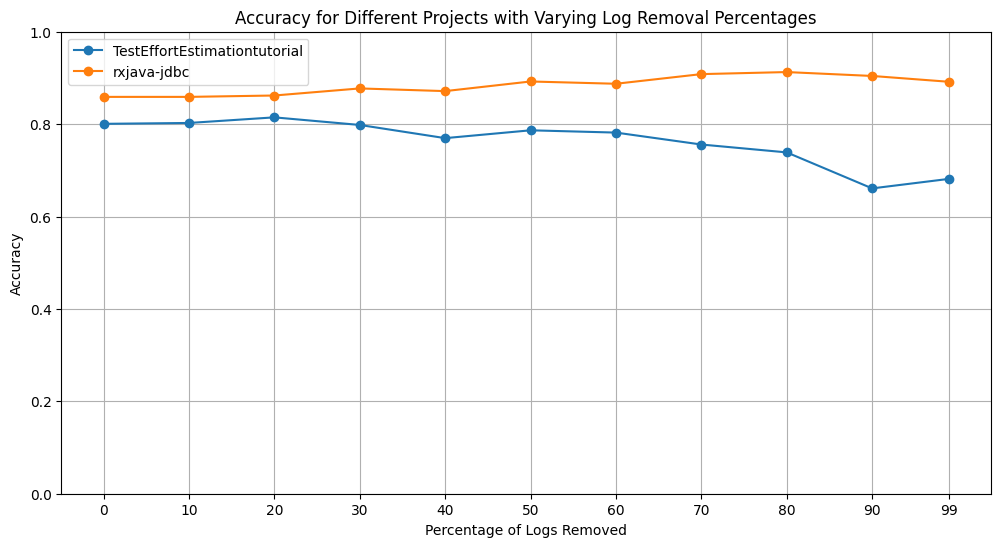

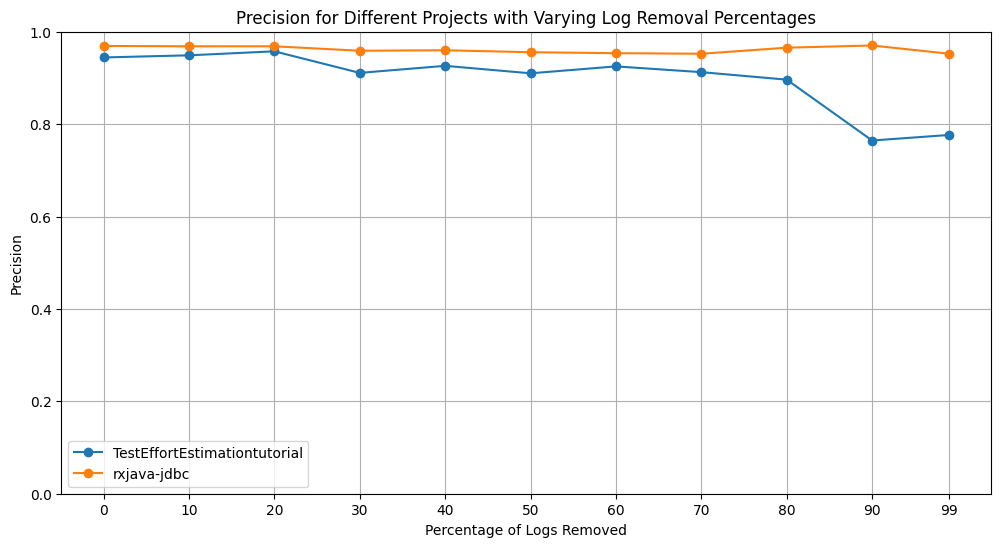

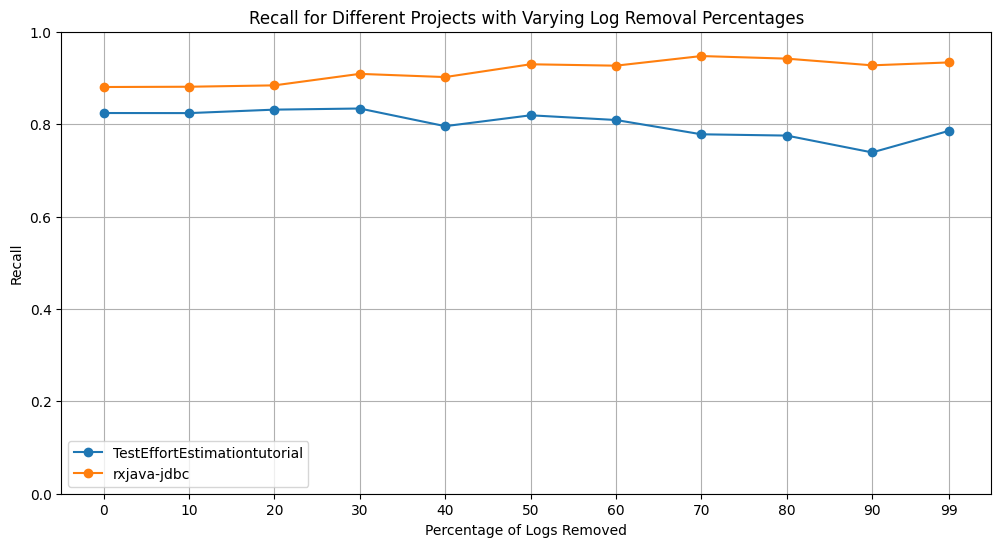

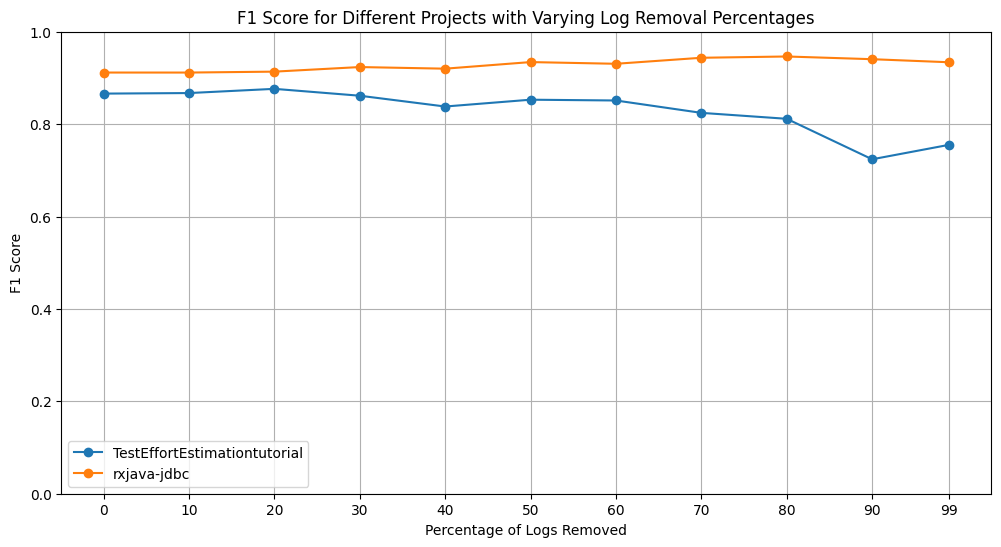

In [1]:

import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm.notebook import tqdm 

def vectorize_log_file(file_path, vectorizer=None, fit=True):
    all_sentence = []
    with open(file_path, 'r') as file:
        log_content = file.read().strip().split('\n')
        all_sentence.append(extract_all_word_from_log(log_content))
    if not log_content:
        raise ValueError(f"The log file {file_path} is empty or contains only whitespace.")
    if fit:
        log_vector = vectorizer.fit_transform(all_sentence)
    else:
        log_vector = vectorizer.transform(all_sentence)
    return log_vector.toarray()[0]

def extract_all_word_from_log(log_context):
    words = ""
    for line in log_context:
        words += line.split('|')[-1].strip()
    return words

def parse_execution_trace(file_path):
    return pd.read_csv(file_path)

def get_total_line_of_code(file_path):
    data = None
    with open(file_path, 'r') as input_file:
        data = json.load(input_file)
    return data

def vectorize_execution_trace(trace_df, unique_methods, total_lines_of_code):
    execution_vectors = {}

    for method in unique_methods:
        coverage = {path: [0] * lines for path, lines in total_lines_of_code.items()}
        method_trace = trace_df[trace_df['method'] == method]

        for _, row in trace_df.iterrows():
            if str(row['line_no']) in map(str, method_trace['line_no'].values):
                coverage[row['path'].split(';')[0]][row['line_no']-1] = 1
        execution_vectors[method] = [x for y in coverage.values() for x in y]
    return execution_vectors

def extract_result(coverage_vector_result, total_lines_of_code):
    result = {}
    for path, lines in total_lines_of_code.items():
        result[path] = coverage_vector_result[:lines]
        coverage_vector_result = coverage_vector_result[lines:]
    return result



def calculate_accuracy(y_test, y_pred):
    
    return accuracy_score(y_test, y_pred)

def calculate_precision_recall_f1(y_test, y_pred):

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return precision, recall, f1

def god_cutting(actual, predicted):
    # Create a boolean mask where neither actual nor pred are 0

    mask = ~((actual == 0) & (predicted == 0))

    god_actual = actual[mask]
    god_predicted = predicted[mask]

    return god_actual, god_predicted


def evaluate_predictions(method_test, y_test, y_pred, total_lines_of_code):
    prediction_percentage = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    for i in range(len(y_test)):
        actual_coverage = extract_result(y_test[i], total_lines_of_code)
        predicted_coverage = extract_result(y_pred[i], total_lines_of_code)
        
        total_acc = []
        total_prec = []
        total_recall = []
        total_f1 = []
        for path in total_lines_of_code.keys():
            actual = actual_coverage[path]
            predicted = predicted_coverage[path]
            actual = np.array(actual)
            predicted = np.array(predicted)
            actual, predicted = god_cutting(actual, predicted)

                    
            if len(actual) == 0:
                continue
            
            acc = calculate_accuracy(actual, predicted)
            prec, recall, f1 = calculate_precision_recall_f1(actual, predicted)
            
            total_acc.append(acc)
            total_prec.append(prec)
            total_recall.append(recall)
            total_f1.append(f1)

        acc = np.mean(total_acc)
        prec = np.mean(total_prec)
        recall = np.mean(total_recall)
        f1 = np.mean(total_f1)  

        prediction_percentage.append(acc)
        precision_scores.append(prec)
        recall_scores.append(recall)
        f1_scores.append(f1)

    return prediction_percentage, precision_scores, recall_scores, f1_scores


# Directory structure
projects = ['TestEffortEstimationtutorial', 'rxjava-jdbc']
base_directory = 'data'

# Lists to store results for each project
project_results = {project: {"accuracies": [], "precisions": [], "recalls": [], "f1s": [], "percentages": []} for project in projects}

# Iterate through each project
for project in tqdm(projects):
    project_path = os.path.join(base_directory, project)
    total_lines_of_code = get_total_line_of_code(os.path.join(project_path, 'line_of_code.json'))
    
    # Iterate through each dataset directory
    for folder in tqdm(sorted(os.listdir(os.path.join(project_path, 'percentage_of_removed_log'))), desc=f"Processing {project}"):
        folder_path = os.path.join(project_path, 'percentage_of_removed_log', folder)
        if not os.path.isdir(folder_path):
            continue

        percentage = int(folder)
        project_results[project]["percentages"].append(percentage)

        acc_list = []
        prec_list = []
        recall_list = []
        f1_list = []

        for attempt in tqdm(sorted(os.listdir(folder_path)), desc=f"Processing attempts for {percentage}%", leave=False):
            attempt_path = os.path.join(folder_path, attempt)
            if not os.path.isdir(attempt_path):
                continue

            log_directory = os.path.join(attempt_path, 'logs')
            trace_file = os.path.join(attempt_path, 'trace_data.csv')
            try:
                trace_df = parse_execution_trace(trace_file)
            except FileNotFoundError as e:
                print(f"Trace file not found for percentage {percentage}, attempt {attempt}. Skipping...")
                continue
            trace_df = trace_df[~trace_df['path'].str.contains(r'\btest\b|\bTest\b', regex=True)]
            trace_df['line_no'] = trace_df['path'].apply(lambda x: int(x.split('@')[1]))
            trace_df['method'] = trace_df['signature'].str.replace(r'.*?\.java;.*?\.', '', regex=True).str.replace('#', '', regex=True)
            unique_methods = trace_df['method'].unique()

            execution_vectors = vectorize_execution_trace(trace_df, unique_methods, total_lines_of_code)

            log_vectors = []
            execution_vectors_for_model = []
            method_names = []
            vectorizer = CountVectorizer()

            for method in unique_methods:
                log_file_path = os.path.join(log_directory, f"log_{method}.log")
                log_file_path = log_file_path.replace('"', '')

                if os.path.exists(log_file_path):
                    try:
                        log_vector = vectorize_log_file(log_file_path, vectorizer, fit=True)
                        log_vectors.append(log_vector)
                        execution_vectors_for_model.append(execution_vectors[method])
                        method_names.append(method)
                    except ValueError as e:
                        print(e)
                else:
                    print(f"Log file for method {method} not found.")

            if len(log_vectors) < 2 or len(execution_vectors_for_model) < 2:
                print(f"Insufficient data for percentage {percentage}, attempt {attempt}. Skipping...")
                continue

            max_log_length = max(len(v) for v in log_vectors)
            max_exec_length = max(len(v) for v in execution_vectors_for_model)

            padded_log_vectors = np.array([np.pad(v, (0, max_log_length - len(v)), 'constant') for v in log_vectors])
            padded_execution_vectors = np.array([np.pad(v, (0, max_exec_length - len(v)), 'constant') for v in execution_vectors_for_model])

            X = np.array(padded_log_vectors)
            y = np.array(padded_execution_vectors)

            X_train, X_test, y_train, y_test, method_train, method_test = train_test_split(X, y, method_names, test_size=0.33, random_state=42)

            clf = RandomForestClassifier(n_estimators=100, random_state=42)
            clf.fit(X_train, y_train)

            y_pred = clf.predict(X_test)

            acc, prec, recall, f1 = evaluate_predictions(method_test, y_test, y_pred, total_lines_of_code)
            
            acc_list.extend(acc)
            prec_list.extend(prec)
            recall_list.extend(recall)
            f1_list.extend(f1)

        avg_acc = np.mean(acc_list)
        avg_prec = np.mean(prec_list)
        avg_recall = np.mean(recall_list)
        avg_f1 = np.mean(f1_list)
        
        project_results[project]["accuracies"].append(avg_acc)
        project_results[project]["precisions"].append(avg_prec)
        project_results[project]["recalls"].append(avg_recall)
        project_results[project]["f1s"].append(avg_f1)



import json

def dump_results_to_json(project_results, filename='project_results.json'):
    with open(filename, 'w') as json_file:
        json.dump(project_results, json_file, indent=4)

dump_results_to_json(project_results, 'project_results.json')



metrics = ['accuracies', 'precisions', 'recalls', 'f1s']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

for metric, metric_name in zip(metrics, metric_names):
    plt.figure(figsize=(12, 6))
    for project, results in project_results.items():
        plt.plot(results["percentages"], results[metric], marker='o', label=project)
    plt.xlabel('Percentage of Logs Removed')
    plt.ylabel(metric_name)
    plt.ylim(0, 1)
    plt.xticks(results["percentages"])
    plt.legend()
    plt.grid(True)
    plt.title(f'{metric_name} for Different Projects with Varying Log Removal Percentages')
    plt.show()


In [2]:
import json

def dump_results_to_json(project_results, filename='project_results1.json'):
    with open(filename, 'w') as json_file:
        json.dump(project_results, json_file, indent=4)

dump_results_to_json(project_results, 'project_results.json')

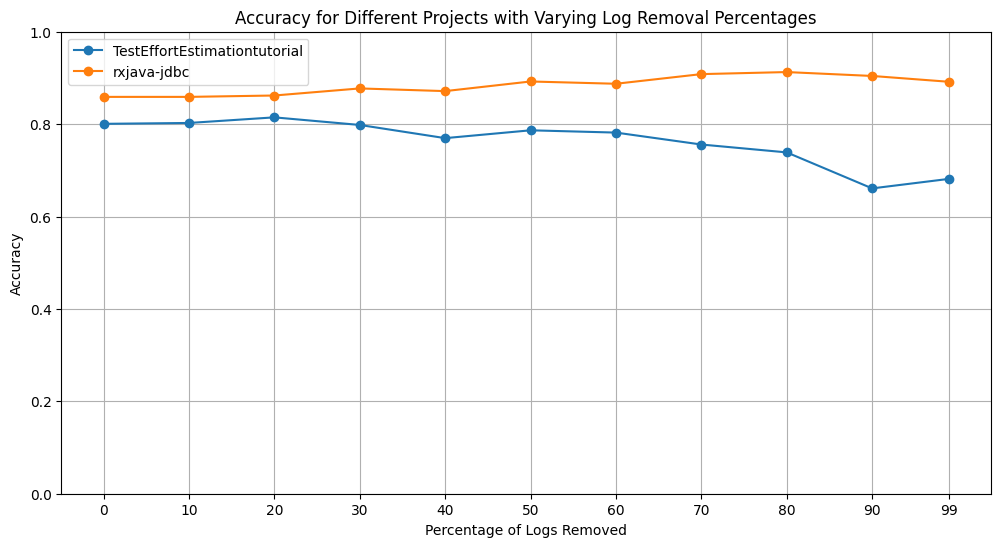

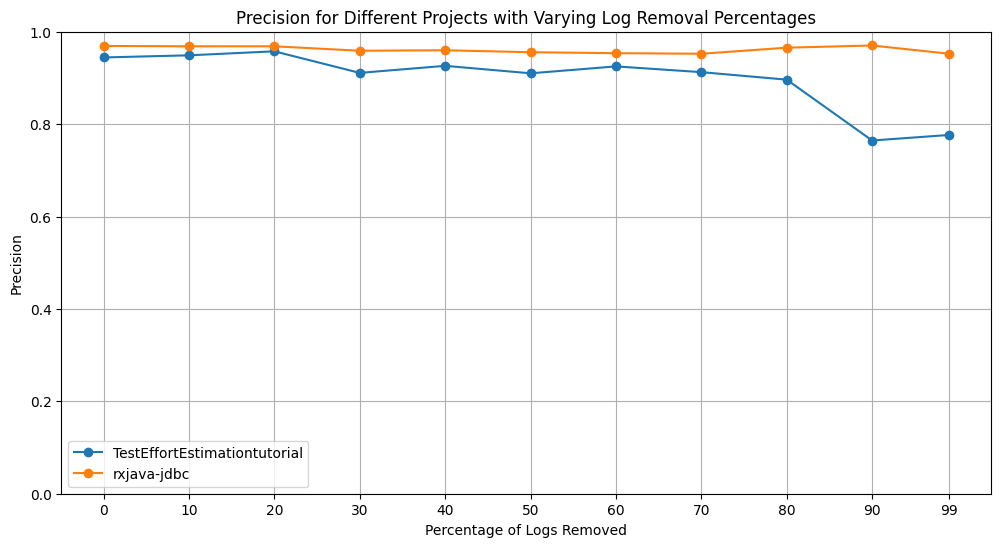

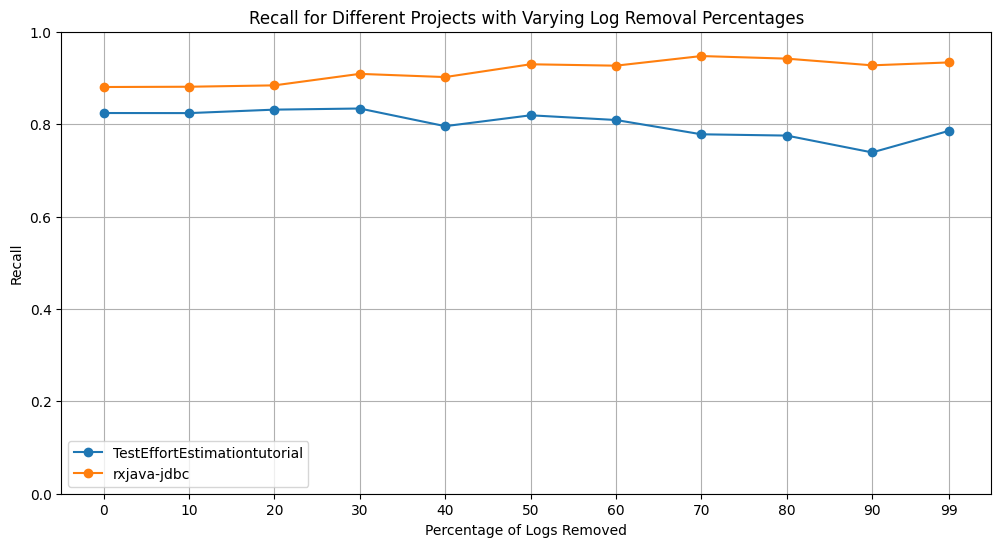

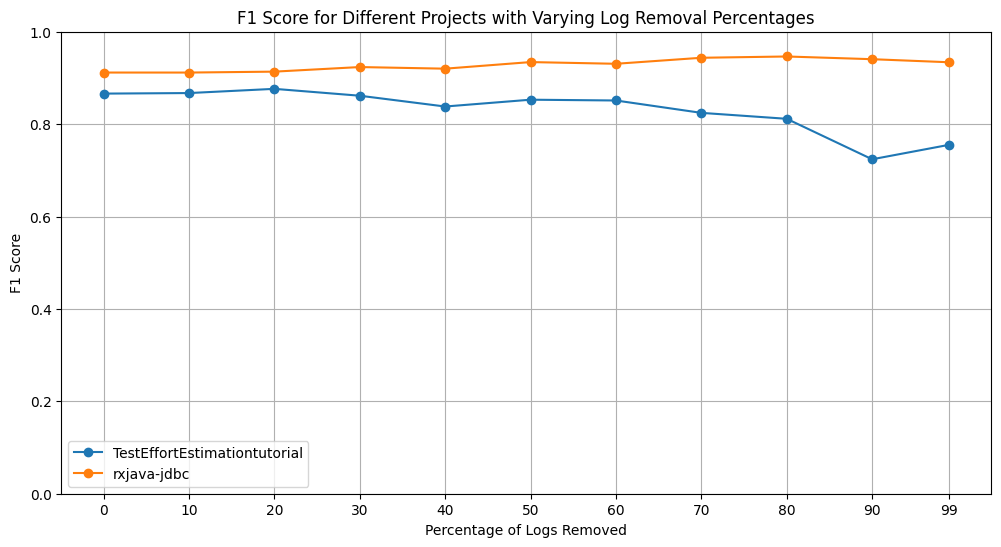

In [5]:

metrics = ['accuracies', 'precisions', 'recalls', 'f1s']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

for metric, metric_name in zip(metrics, metric_names):
    plt.figure(figsize=(12, 6))
    for project, results in project_results.items():
        plt.plot(results["percentages"], results[metric], marker='o', label=project)
    plt.xlabel('Percentage of Logs Removed')
    plt.ylabel(metric_name)
    plt.ylim(0, 1)
    plt.xticks(results["percentages"])
    plt.legend()
    plt.grid(True)
    plt.title(f'{metric_name} for Different Projects with Varying Log Removal Percentages')
    plt.show()

In [4]:
for project, results in project_results.items():
    print(results["percentages"], results["accuracies"])
    print(results["percentages"], results["precisions"])
    print(results["percentages"], results["recalls"])
    print(results["percentages"], results["f1s"])


[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99] [0.8006280494134745, 0.8025060476423898, 0.8146438446843306, 0.7981948346039475, 0.7696584293537027, 0.7866139862466563, 0.7816736078835009, 0.7558415748207328, 0.7388101468657637, 0.6608827509545214, 0.6814840130629605]
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99] [0.9443106039259885, 0.9489144829529446, 0.9575777214238753, 0.9109125391912277, 0.9261618832485973, 0.9099876899057228, 0.9249563820018365, 0.912508472167563, 0.8962389198103483, 0.7645316804407714, 0.776540404040404]
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99] [0.8240300119557086, 0.823849814483894, 0.8313461820654009, 0.8337943310038297, 0.7955615057101659, 0.8190988798754749, 0.8089225910749974, 0.7779929731216495, 0.7751951946279676, 0.7387429489702217, 0.785515873015873]
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99] [0.8660533481798337, 0.8672322531265048, 0.8763511582020933, 0.8614754261671355, 0.8381015427044445, 0.852858472371157, 0.8511424273681356, 0.8243746003030754, 0.811